<a href="https://colab.research.google.com/github/AeMcRa/Datascience-things/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

with pm.Model(coords=aa_coords) as cs_st_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, nu = 1, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 1)
    μ_nu = pm.HalfStudentT('μ_nu', sigma = 10, nu = 1)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = 1,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10, nu = 1,
                      dims = "aa")

    ν = pm.HalfStudentT('ν',sigma = 7, nu= 1, dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_st = pm.sample()

Output()

Output()

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

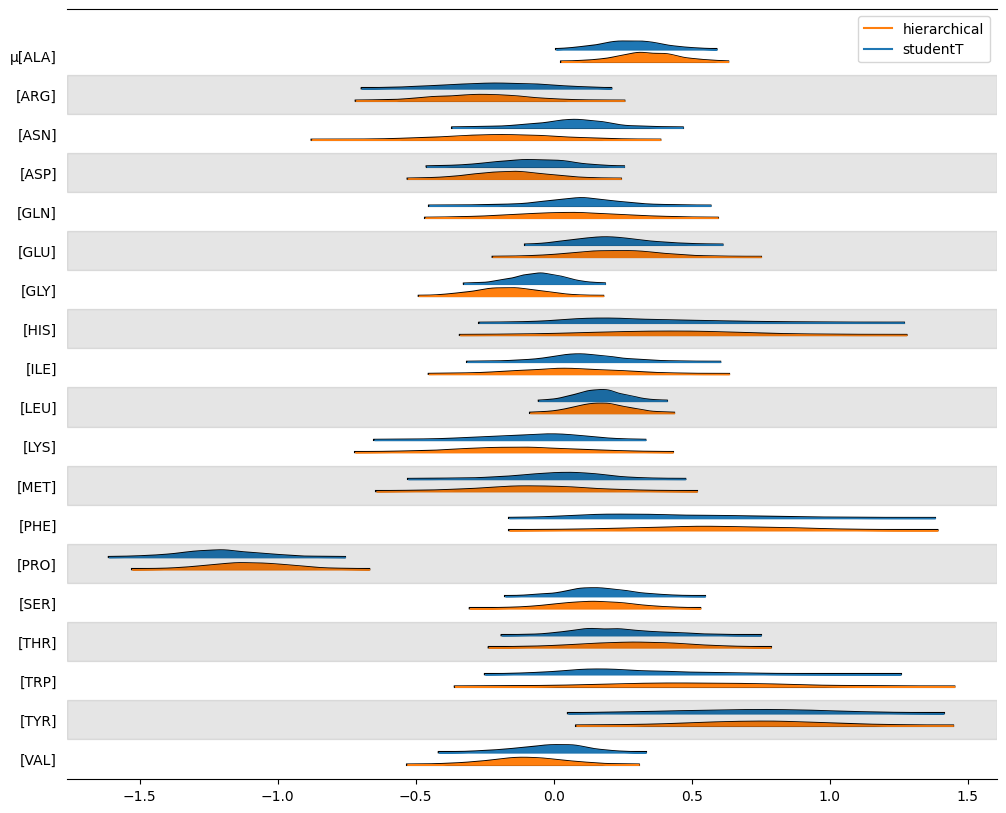

In [ ]:
axes = az.plot_forest([idata_cs_st, idata_cs_h], kind="ridgeplot",
                      model_names=['studentT', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)


**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model = cs_h_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

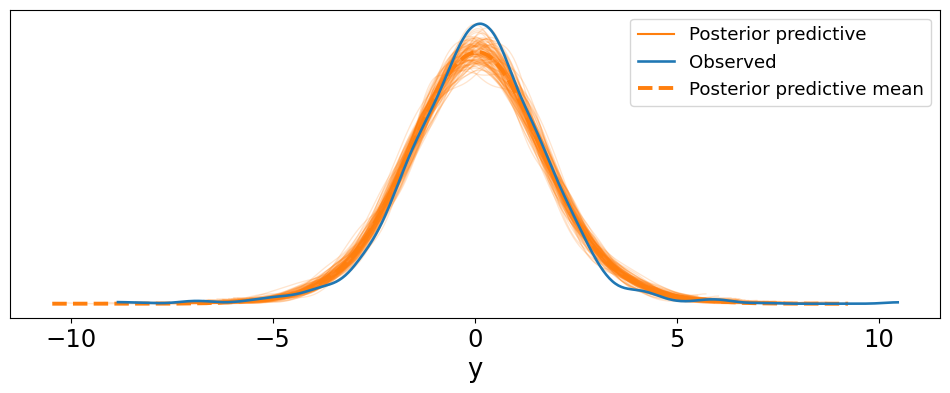

In [ ]:
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

In [ ]:
pm.sample_posterior_predictive(idata_cs_st, model = cs_st_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

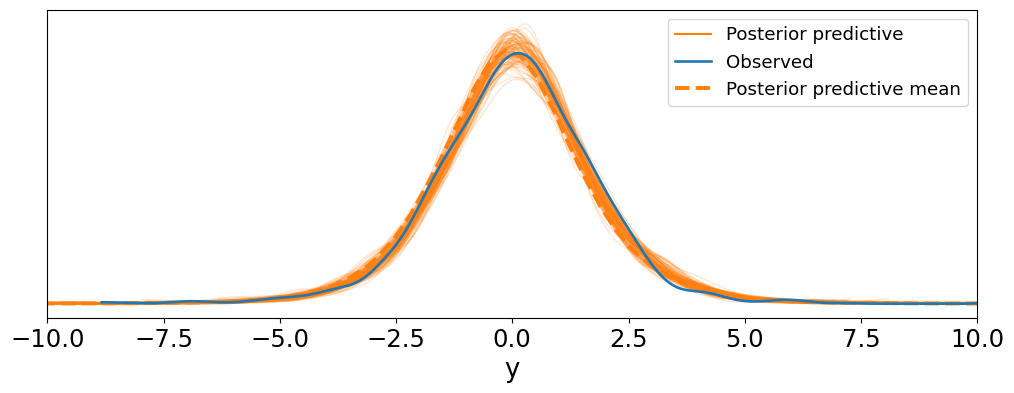

In [ ]:
az.plot_ppc(idata_cs_st, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]).set_xbound(lower = -10, upper = 10)

Student T seems to fit the data better. The normal distribution is not pointy enough, but StudentT has kurtosis so we can make it pointy.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    #
    #μ = pm.Beta('μ', alpha = 2, beta = 20)
    #ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = .09, nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

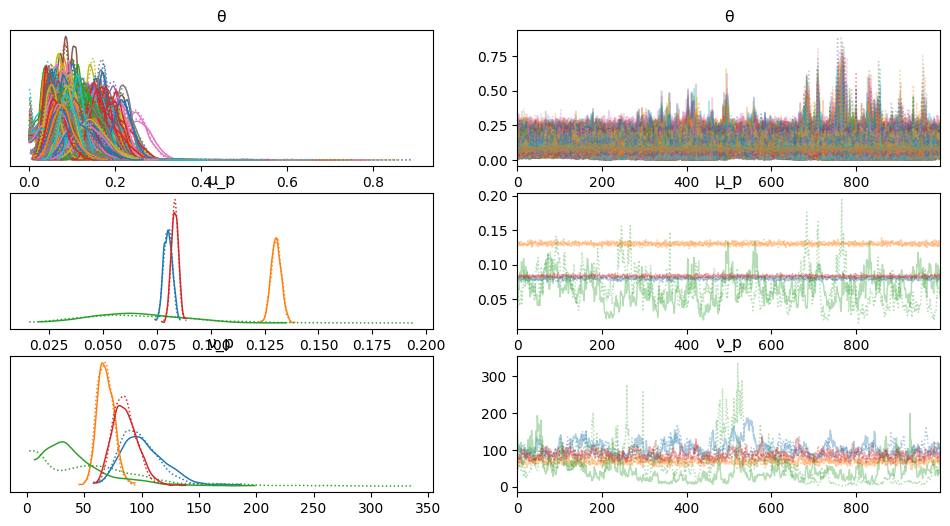

In [ ]:
az.plot_trace(idata_sccr)


In [ ]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.0 1.002 1.002 ... 0.9992 1.0 0.9995
    μ_p      (pos) float64 32B 1.002 0.9991 1.065 1.002
    ν_p      (pos) float64 32B 1.008 1.002 1.153 1.003

the nonheirarchical has 2 less rows,(its missing the blue ones). I assume that these are the hyperpriors. Other than missing those, the amplitudes of the graphs look pretty much similar, but on the μ_p graph, the spikes are more concentrated on 800 rather than 200. it seems that the μ rhat is a little bit better on the nonheirarchical. The ν rhat is still similar

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

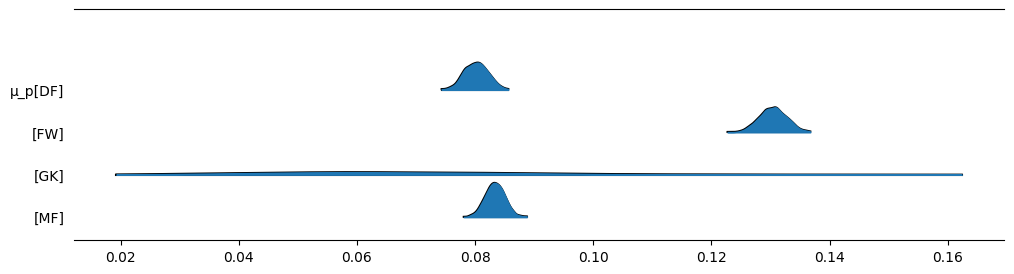

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

my posteriors seem to be in relatively the same positions as the previous posterior means, however the GK mean seams to be more widely distributed comparativly. I think this is due to the variability in the GK data that changes the mean on a sample to sample basis.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
url_sccr_nog = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data_nog = pd.read_csv(url_sccr_nog,dtype={'position':'category'})
sccr_data_nog = sccr_data_nog[sccr_data_nog.position != 'GK']
sccr_data_nog.position = sccr_data_nog.position.cat.remove_categories('GK')
#except they are given an int (number) label instead of a string (of letters)
pos_idx_nog = sccr_data_nog.position.cat.codes.values

#an array of the four strings that represent position
pos_codes_nog = sccr_data_nog.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords_nog = {"pos": pos_codes_nog}

with pm.Model(coords = sccr_coords_nog) as sccr_model_nog:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_nog], nu = ν_p[pos_idx_nog])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_nog.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_nog.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_nog = pm.sample(target_accept = 0.95)


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

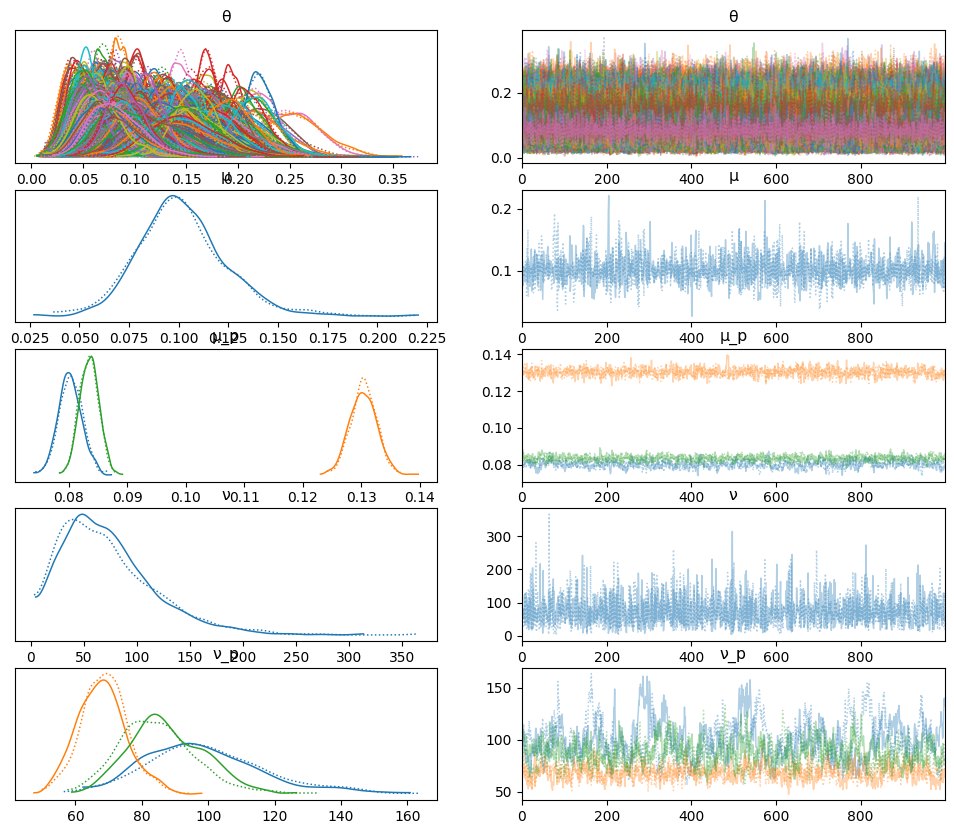

In [ ]:
az.plot_trace(idata_sccr_nog)


In [ ]:
az.rhat(idata_sccr_nog)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.001 1.002 0.9995 ... 1.002 1.001 1.001
    μ        float64 8B 1.0
    μ_p      (pos) float64 24B 1.001 1.004 1.001
    ν        float64 8B 1.005
    ν_p      (pos) float64 24B 1.02 1.003 1.015

the model without goalkeeper took only 5 minutes as opposed to the gk's 7 minutes.

without goalkeepers, we can create a better model, however we lose the ability to model for goalkeepers